In [1]:
# importing modules

import os
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
from tensorflow.keras.applications.vgg19 import decode_predictions
from tensorflow.keras.models import Model
from tensorflow.linalg import einsum
from tensorflow.keras.optimizers import Adam
from IPython import display

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import numpy as np
import PIL.Image
import time
import functools
import matplotlib.pyplot as plt

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
content_path = "./img/IMG_0171.jpg"
style_path = "./img/europeana-qi9jveT9X6A-unsplash.jpg"

In [5]:
def load_img(path_to_img: str):
    """
    Function to load image into tensor

    Args:
        path_to_img (str): path to image on device

    Return:
        Returns scaled image tensor
    """

    # maximum dimensions for image
    max_dim = 512

    # read image into memory
    img = tf.io.read_file(path_to_img)
    # decode image into a tensor with 3 channels
    img = tf.image.decode_image(img, channels=3)
    #convert image tensor data type
    img = tf.image.convert_image_dtype(img, tf.float32)

    """Operations to scale down image to max_dim"""
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)

    # get scale ratio
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)

    # adding an extra dimension to the array
    img = img[tf.newaxis, :]
    return img

In [6]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

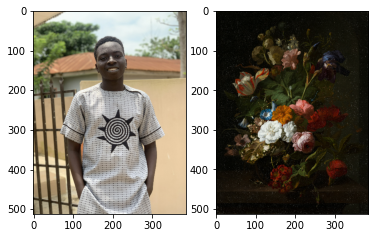

In [8]:
plt.subplot(1, 2, 1)
imshow(content_image)

plt.subplot(1, 2, 2)
imshow(style_image)

In [9]:
x = preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = VGG19(
    include_top=True,
    weights='imagenet'
)


In [10]:
prediction_prob = vgg(x)
prediction_prob.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = decode_predictions(prediction_prob.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('jersey', 0.107804835),
 ('cardigan', 0.08692024),
 ('pajama', 0.048755538),
 ('poncho', 0.04267539),
 ('strainer', 0.037969183)]

In [12]:
vgg = VGG19(include_top=False, weights='imagenet')

In [13]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content = len(content_layers)
num_style = len(style_layers)

In [15]:
def vgg_layers(layer_names):
    vgg = VGG19(
        include_top=False,
        weights="imagenet"
    )
    vgg.trainable=False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = Model([vgg.input], outputs)

    return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)
# style_outputs

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())
    print()

block1_conv1
 shape:  (1, 512, 385, 64)
 min:  0.0
 max:  788.5384
 mean:  10.65913

block2_conv1
 shape:  (1, 256, 192, 128)
 min:  0.0
 max:  3826.0442
 mean:  64.778145

block3_conv1
 shape:  (1, 128, 96, 256)
 min:  0.0
 max:  6506.591
 mean:  70.669044

block4_conv1
 shape:  (1, 64, 48, 512)
 min:  0.0
 max:  17922.262
 mean:  292.26025

block5_conv1
 shape:  (1, 32, 24, 512)
 min:  0.0
 max:  1799.1149
 mean:  23.06724



In [17]:
def gram_matrix(input_tensor):
    result = einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

In [18]:
class StyleContentModel(Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        """Expects float input in [0, 1]"""
        inputs = inputs * 255.0
        preprocessed_input = preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers],
            outputs[self.num_style_layers:]
        )

        style_outputs = [
            gram_matrix(style_output) for style_output in style_outputs
            ]
        
        content_dict = {
            "content_name": value for style_name, value in zip(
            self.style_layers, style_outputs
            )
        }

        style_dict = {
            "style_name": value for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {'content': content_dict, 'style': style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   style_name
    shape:  (1, 512, 512)
    min:  0.0
    max:  107220.19
    mean:  1936.946

Contents:
   content_name
    shape:  (1, 512, 512)
    min:  0.0
    max:  107220.19
    mean:  1936.946


In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [21]:
image = tf.Variable(content_image)

In [22]:
def clip_0_1(image):
    return tf.clip_by_value(image, 0.0, 1.0)

In [23]:
opt = Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [24]:
style_weight = 1e-2
content_weight=1e4

In [25]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs["content"]

  style_loss = tf.add_n([
    tf.reduce_mean(
      (style_outputs[name] - style_targets[name]) ** 2
    )
    for name in style_outputs.keys()
  ])
  style_loss *= style_weight / num_style

  content_loss = tf.add_n([
    tf.reduce_mean(
      (content_outputs[name] - content_targets[name]) ** 2
    ) for name in content_outputs.keys()
  ])

  content_loss *= content_weight / num_content
  loss = style_loss + content_loss

  return loss

In [26]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

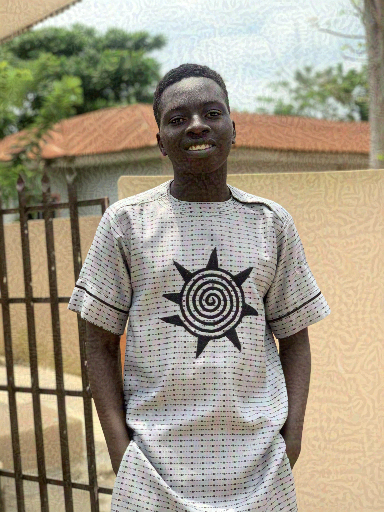

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="", flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


...........................................................

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

In [ ]:
tf.image.total_variation(image).numpy()

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)
      loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradients(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))